In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

***Gaussian Process with unimodality constraint.***
=====

In [2]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn import preprocessing
import pickle
from hashlib import md5
import time
import os

def StanModel_cache(model_code, model_name=None, **kwargs):
    """Use just as you would `stan`"""
    path = "../Stan files/pkl_cache"
    if(os.path.isdir(path)==False):
        os.makedirs(path)
    
    code_hash = md5(model_code.encode('ascii')).hexdigest()
    if model_name is None:
        cache_fn = '{}/cached-model-{}.pkl'.format(path,code_hash)
    else:
        cache_fn = '{}/cached-{}-{}.pkl'.format(path,model_name, code_hash)
    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        sm = pystan.StanModel(model_code=model_code)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm

In [3]:
prior_model = StanModel_cache(model_code=open("../Stan files/prior.stan").read())

Using cached StanModel


In [4]:
uni_prior_model = StanModel_cache(model_code=open("../Stan files/prior uni.stan").read())

Using cached StanModel


In [5]:
cnt_xp = 40
xp = np.linspace(-10,4,cnt_xp)
    
prior_data = dict(
    N = len(xp),
    x = xp
)

In [6]:
prior_fit = prior_model.sampling(data=prior_data,iter=1000,chains=1)
#print(prior_fit)

In [7]:
prior_arr = prior_fit.extract(permuted=True)
prior = prior_arr['f']

In [8]:
cnt_m = 60
xm = np.linspace(-10,10,cnt_m)
m = np.ones_like(xm,dtype=int)
v_value = 0.001

In [9]:
uni_prior_data = dict(
    N = len(xp),
    x = xp,
    N_g = cnt_m,
    x_g = xm,
    m = m,
    v = v_value
)

In [10]:
uni_prior_fit = uni_prior_model.sampling(data=uni_prior_data,iter=1000,chains=1)
#print(uni_prior_fit)

In [11]:
uni_prior_arr = uni_prior_fit.extract(permuted=True)
sim_uni_prior = uni_prior_arr['f']
_a = uni_prior_arr['a']
_b = uni_prior_arr['b']

/usr/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


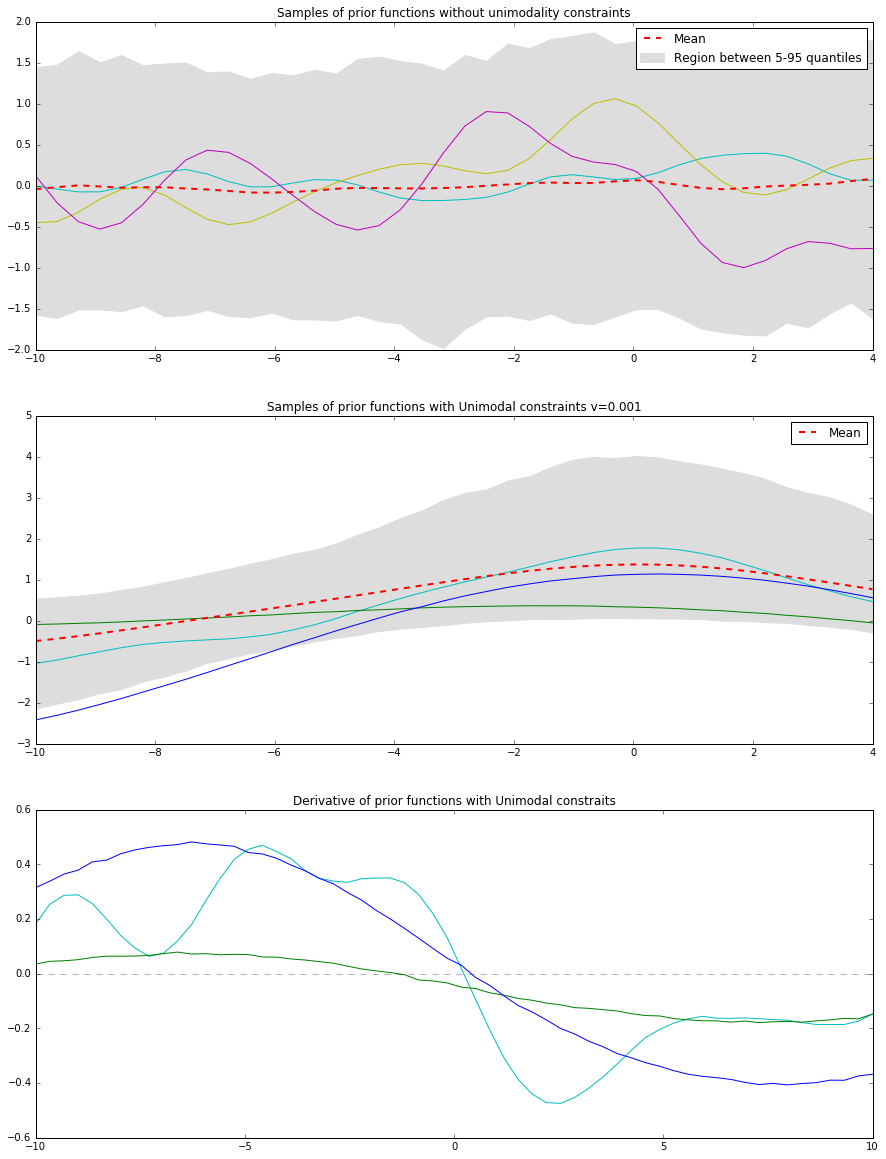

In [12]:
p = np.random.randint(sim_uni_prior.shape[0],size=3)
pp = np.random.randint(prior.shape[0],size=3)
pr_q5 = np.percentile(prior,5,axis=0)
pr_q95 = np.percentile(prior,95,axis=0)
pr_mean = np.mean(prior,axis=0)
m_pr_q5 = np.percentile(sim_uni_prior[0:,:cnt_xp],5,axis=0)
m_pr_q95 = np.percentile(sim_uni_prior[0:,:cnt_xp],95,axis=0)
m_pr_mean = np.mean(sim_uni_prior[0:,:cnt_xp],axis=0)


plt.figure(figsize=(15,20))

ax1 = plt.subplot(311)
plt.title('Samples of prior functions without unimodality constraints')
plt.plot(xp, prior[pp[0]], 'c')
plt.plot(xp, prior[pp[1]], 'y')
plt.plot(xp, prior[pp[2]], 'm')
plt.fill_between(xp, pr_q5, pr_q95, color="#dddddd",label="Region between 5-95 quantiles")
plt.plot(xp,pr_mean,'r--',lw=2,label="Mean" )
plt.legend()


plt.subplot(312)
plt.title('Samples of prior functions with Unimodal constraints v={}'.format(v_value))
plt.plot(xp, sim_uni_prior[p[0]][:cnt_xp], 'c')
plt.plot(xp, sim_uni_prior[p[1]][:cnt_xp], 'g')
plt.plot(xp, sim_uni_prior[p[2]][:cnt_xp], 'b')
plt.fill_between(xp, m_pr_q5, m_pr_q95, color="#dddddd")
plt.plot(xp,m_pr_mean,'r--',lw=2,label="Mean" )
plt.legend()

plt.subplot(313)
plt.title('Derivative of prior functions with Unimodal constraits')
plt.plot(xm, sim_uni_prior[p[0]][cnt_xp:], 'c')
plt.plot(xm, sim_uni_prior[p[1]][cnt_xp:], 'g')
plt.plot(xm, sim_uni_prior[p[2]][cnt_xp:], 'b')
plt.plot(plt.gca().get_xlim(),[0,0],'k--',alpha=0.3)
plt.legend()


# plt.subplot(414,sharex=ax1)
# xval = np.linspace(-10,4,20)
# print(xval)
# plt.title('Derivative of prior functions with Unimodal constraits')
# plt.plot(xval, _a[p[0]]*xval+_b[p[0]], 'c',label="Unimodality inducing line 1")
# plt.plot(xval, _a[p[1]]*xval+_b[p[1]], 'g',label="Unimodality inducing line 2")
# plt.plot(xval, _a[p[2]]*xval+_b[p[2]], 'b',label="Unimodality inducing line 3")
# plt.plot(plt.gca().get_xlim(),[0,0],'k--',alpha=0.3)
# plt.legend()



plt.legend()
plt.savefig("./Fig/%s Unimodal Prior.png"%(time.ctime()))
plt.show()

# Posterior 

In [13]:
posterior_model = StanModel_cache(model_code=open("../Stan files/posterior.stan").read())

Using cached StanModel


In [14]:
uni_posterior_model = StanModel_cache(model_code=open("../Stan files/posterior uni.stan").read())

Using cached StanModel


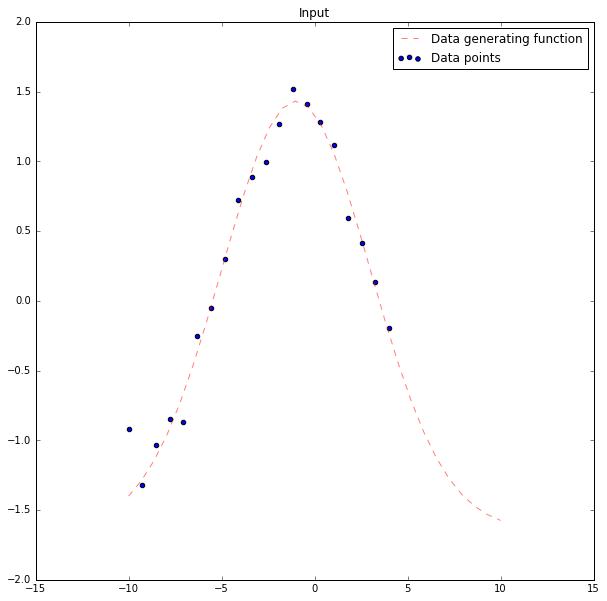

In [17]:
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)

def func(x):
    return gaussian(x,-1,4) #+ gaussian(x,-3,0.5)*0.02



xdata = np.linspace(-10,4,20)
ydata = func(xdata) + np.random.normal(0,0.005,size=len(xdata))
x = np.linspace(-10,10,30)
y = func(x) 
ycombined = preprocessing.scale(np.append(ydata,y))
ydata = ycombined[:len(xdata)]
y = ycombined[len(xdata):]

plt.figure(figsize=(10,10))
plt.scatter(xdata,ydata,label="Data points")
plt.plot(x,y,'r--',alpha=0.5,label="Data generating function")
#plt.scatter(xm,np.zeros_like(xm)+np.min(ycombined),'g',label="Psuedo derivative locations")
plt.title('Input')

plt.legend()
plt.savefig("./Fig/%s Input data points.png"%(time.ctime()))

plt.show()

In [30]:
sig =0.05
v= 0.001

posterior_data = dict(
    N = len(xdata),
    x = xdata,
    y = ydata,
    N_prm = len(x),
    x_prm = x,
    sig_var = sig
)

uni_posterior_data = dict(
    N = len(xdata),
    x = xdata,
    y = ydata,
    N_g = len(xm),
    x_g = xm,
    m = m,
    N_prm = len(x),
    x_prm = x,
    v = v,
    sig_var = sig
)

In [31]:
posterior_fit = posterior_model.sampling(data=posterior_data,iter=1000,chains=1)
#print(posterior_fit)

In [32]:
uni_posterior_fit = uni_posterior_model.sampling(data=uni_posterior_data,iter=1000,chains=1)
#print(uni_posterior_fit)

In [33]:
sim_posterior = posterior_fit.extract(permuted=True)['y_prm']
p_mean = np.mean(sim_posterior,axis=0)
p_std = np.std(sim_posterior,axis=0)
p_q5 = np.percentile(sim_posterior, 5, axis=0)
p_q95 = np.percentile(sim_posterior, 95, axis=0)


In [34]:
uni_sim_posterior = uni_posterior_fit.extract(permuted=True)['y_prm']
u_a = np.mean(uni_posterior_fit.extract(permuted=True)['a'])
u_b = np.mean(uni_posterior_fit.extract(permuted=True)['b'])
u_p_mean = np.mean(uni_sim_posterior,axis=0)
u_p_std = np.std(uni_sim_posterior,axis=0)
u_p_q5 = np.percentile(uni_sim_posterior, 5, axis=0)
u_p_q95 = np.percentile(uni_sim_posterior, 95, axis=0)
print(u_a,u_b)

(-0.94477387000772162, -0.79953932429181518)


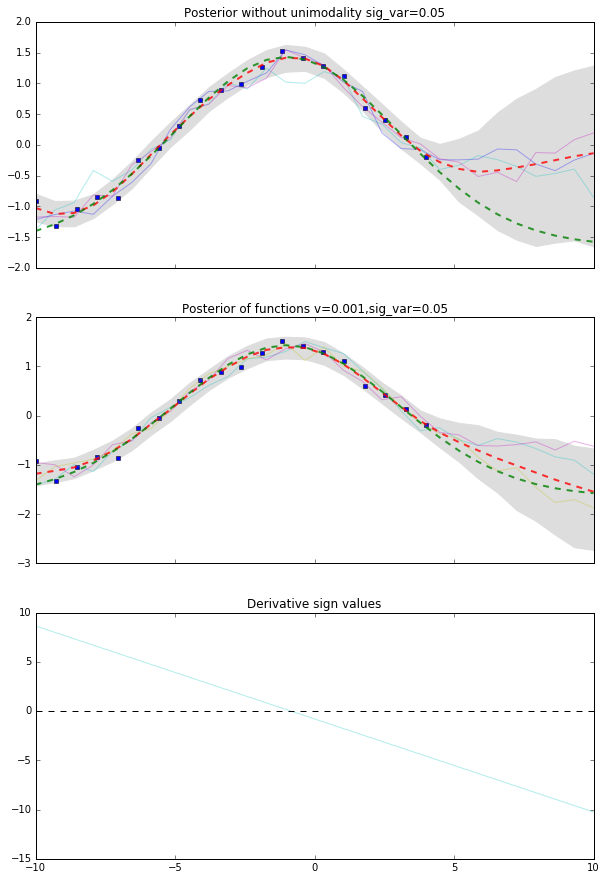

In [35]:
c = ['b', 'c', 'm', 'y']
p = np.random.randint(sim_posterior.shape[0],size=3)
pp = np.random.randint(uni_sim_posterior.shape[0],size=3)


fig,ax = plt.subplots(3,1,sharex=True)
fig.set_size_inches(10,15)
ax[0].set_title('Posterior without unimodality sig_var={}'.format(sig))
ax[0].plot(xdata, ydata, 'bs', ms=4,label="Data points")#  
ax[0].plot(x, sim_posterior[p[0]], c[0],alpha=0.3)
ax[0].plot(x, sim_posterior[p[1]], c[1],alpha=0.3)
ax[0].plot(x, sim_posterior[p[2]], c[2],alpha=0.3)
ax[0].plot(x, p_mean,'r--',alpha=0.8,lw=2,label="mean of posterior simulations")
ax[0].plot(x,y,'g--',alpha=0.8,lw=2,label="Data generating function")
ax[0].fill_between(x, p_q5, p_q95, color="#dddddd")
#ax[0].legend()


#plt.subplot(2,2,2)
ax[1].set_title('Posterior of functions v={},sig_var={}'.format(v,sig))
ax[1].plot(xdata, ydata, 'bs', ms=4,label="Data points")#
ax[1].fill_between(x, u_p_q5, u_p_q95, color="#dddddd")
ax[1].plot(x, uni_sim_posterior[pp[0]], c[1],alpha=0.3)
ax[1].plot(x, uni_sim_posterior[pp[1]], c[2],alpha=0.3)
ax[1].plot(x, uni_sim_posterior[pp[2]], c[3],alpha=0.3)
ax[1].plot(x, u_p_mean, 'r--',alpha=0.8, lw=2,label="mean of posterior simulations")
ax[1].plot(x,y,'g--',alpha=0.8,lw=2,label="Data generating function")
#ax[1].legend()


ax[2].set_title('Derivative sign values')
ax[2].plot(x, u_a*x+u_b, c[1],alpha=0.3,label="posterior-function1")
ax[2].plot(plt.gca().get_xlim(),[0,0],'k--')



plt.savefig("./Fig/%s Posterior.png"%(time.ctime()))
plt.show()